In [1]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/video_games.json.gz

--2024-03-31 20:28:25--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/video_games.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 522823613 (499M) [application/x-gzip]
Saving to: ‘video_games.json.gz’

video_games.json.gz 100%[===================>] 498.60M  18.2MB/s    in 21s     

2024-03-31 20:28:46 (23.5 MB/s) - ‘video_games.json.gz’ saved [522823613/522823613]



In [2]:
import gzip # importo esta libreria para descomprimir los archivo .gz
import json # esta libreria la utilizo para trabajar con el formato json
import pandas as pd #importo la libreria de pandas para hacer un dataframe
import re # importo esta libreria para localizar elementos en una cadena de texto
from nltk import ngrams # Libreria para encontrar los ngrams
from nltk.probability import FreqDist # Libreria para encontrar la frecuencia de los ngrams
from collections import Counter # Libreria para realizar el conteo de las palabras
import matplotlib.pyplot as plt # Libreria para hacer las graficas que necesito
import matplotlib.cm as cm # Para visualizar datos de graficos en colores
%matplotlib inline
from wordcloud import WordCloud # Libreria para hacer el worldCloud del vocabulario
from gensim.models import Word2Vec # para hacer el embedding
import multiprocessing # libreria para contar las cpu´s
import numpy as np # para transformar en numpy.array y trabajar con ellos
from sklearn.manifold import TSNE # esta libreria se utiliza para reducir la dimensionalidad
from gensim.models.word2vec import LineSentence # para leer archivos por linea y tokenizar palabras


In [3]:
# Hago una funcion para hayar el wordcloud del corpus

def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Funcion para hacer la grafica 2D de las palabras similares
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()



In [4]:
# almaceno en data_videojuegos el archivo comprimido
data_videojuegos = 'video_games.json.gz'

# Lista para almacenar los datos
videojuegos_json = []

# Abro el archivo comprimido y lo descomprimo.Voy guardando el contenido en la variable creada videojuego_json
with gzip.open(data_videojuegos, 'rb') as data:
    for linea in data:
        linea_str = linea.decode('utf-8')
        try:
            objeto_json = json.loads(linea_str)
            videojuegos_json.append(objeto_json)
        except json.JSONDecodeError:
            videojuegos_json.append(linea_str)




In [5]:
# Hago un data frame del archivo json descargado
df = pd.DataFrame(videojuegos_json)

df.shape

(2565349, 12)

In [6]:
# Creo un csv del dataframe creado y lo guardo en google drive para poder acceder en cualquier momento
df.to_csv('data_lenguage.csv', sep=';', index=False)

from google.colab import drive
drive.mount('/content/drive')

!cp data_lenguage.csv /content/drive/MyDrive/data_lenguage.csv

Mounted at /content/drive


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# accedo al archivo csv y lo guardo en una variable

data_lenguage = pd.read_csv("/content/drive/MyDrive/data_lenguage.csv", sep=';')
data_lenguage.shape

<ipython-input-8-36a62402fe7b>:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data_lenguage = pd.read_csv("/content/drive/MyDrive/data_lenguage.csv", sep=';')


(2565349, 12)

In [9]:
data_lenguage.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image'],
      dtype='object')

In [10]:
# Limito el dataset a 15000 registros porque la cpu no me permite muchos mas registros al ejecutar el notebook completo

lenguage_limited = data_lenguage.iloc[:15000]
lenguage_limited.shape

(15000, 12)

In [11]:
# paso a minusculas el corpus y lo separo en tokens

splitted_reviews = lenguage_limited['reviewText'].str.lower().str.split()

In [12]:
# Paso las reviews a serie de panda y la transformo en una columna

words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)


In [13]:
# Hayo el vocabulario contando las palabras

vocabulary_ = Counter(words)


In [14]:
# longitud del vocabulario

len(vocabulary_)

69262

In [15]:
# 10 palabras mas comunes

wf_most_common = vocabulary_.most_common(10)

In [16]:
wf_most_common

[('the', 76178),
 ('and', 39301),
 ('a', 33329),
 ('to', 32937),
 ('i', 28623),
 ('of', 26293),
 ('is', 25404),
 ('it', 23368),
 ('this', 21778),
 ('you', 21572)]

In [17]:
# separo palabras y frecuencia

words1 = [w[0] for w in wf_most_common]
freqs1 = [w[1] for w in wf_most_common]

In [18]:
# Ordeno

freqs1, words1 = zip(*sorted(zip(freqs1, words1)))

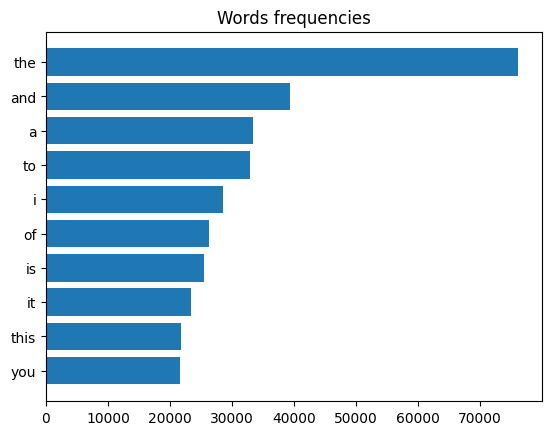

In [19]:
# Hago las grafica de barras

plt.barh(words1, freqs1)
plt.title('Words frequencies')
plt.show()

In [20]:
# Obtengo los bigrams y los trigrams

bigrams_ = list(ngrams(words, 2))
trigrams_ = list(ngrams(words, 3))

In [21]:
# hayo las frecuencias de los bigrams y los trigrams

bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [22]:
# Bigrams mas frecuentes

bgrams = bigrams_freq_.most_common(10)
bgrams

[(('this', 'game'), 7783),
 (('of', 'the'), 7365),
 (('the', 'game'), 5572),
 (('in', 'the'), 4088),
 (('if', 'you'), 3692),
 (('game', 'is'), 3369),
 (('is', 'a'), 3352),
 (('this', 'is'), 3118),
 (('and', 'the'), 2983),
 (('it', 'is'), 2821)]

In [23]:
# separo palabras y frecuencia de los bigrams

bgrams1 = [w[0] for w in bgrams]
freqs_bgrams1 = [w[1] for w in bgrams]

In [24]:
# Ordeno los bigrams y las frecuencias

freqs_bgrams1, bgrams1 = zip(*sorted(zip(freqs_bgrams1, bgrams1)))

In [25]:
# Meto en un str el valor[0] de los bigrams
bgs_ = [str(bg[0]) for bg in bgrams]


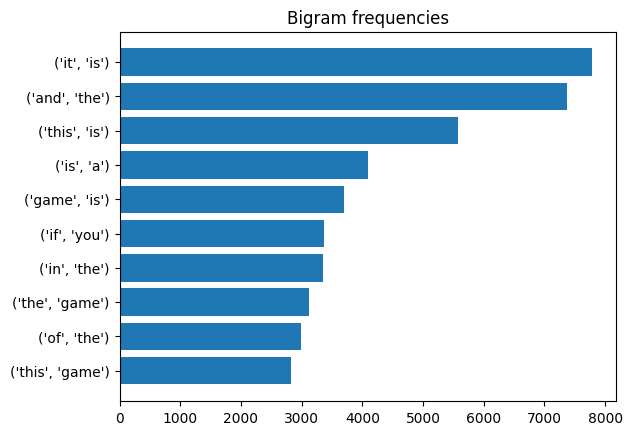

In [26]:
# Hago las grafica de barras

plt.barh(bgs_, freqs_bgrams1)
plt.title('Bigram frequencies')
plt.show()

In [27]:
# Trigrams mas frecuentes

trgrams = trigrams_freq_.most_common(10)
trgrams

[(('this', 'game', 'is'), 2163),
 (('one', 'of', 'the'), 1558),
 (('the', 'game', 'is'), 937),
 (('this', 'is', 'a'), 835),
 (('a', 'lot', 'of'), 802),
 (('the', 'graphics', 'are'), 782),
 (('of', 'the', 'best'), 714),
 (('this', 'is', 'the'), 655),
 (('you', 'have', 'to'), 646),
 (('is', 'one', 'of'), 632)]

In [28]:
# Meto en un str el valor[0] de los trigrams y meto en una variable la frecuencia

tgs_ = [str(tg[0]) for tg in trgrams]
tgs_f_ = [tg[1] for tg in trgrams]

In [29]:
# Ordeno los trigrams

tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

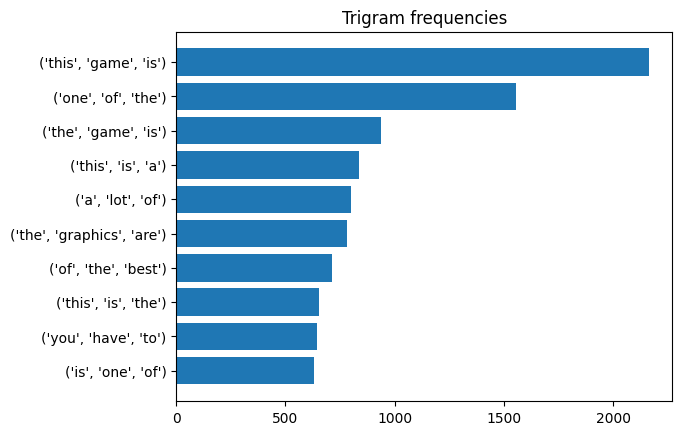

In [30]:
# Hago el diagrama de barras de los trigrams

plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')
plt.show()

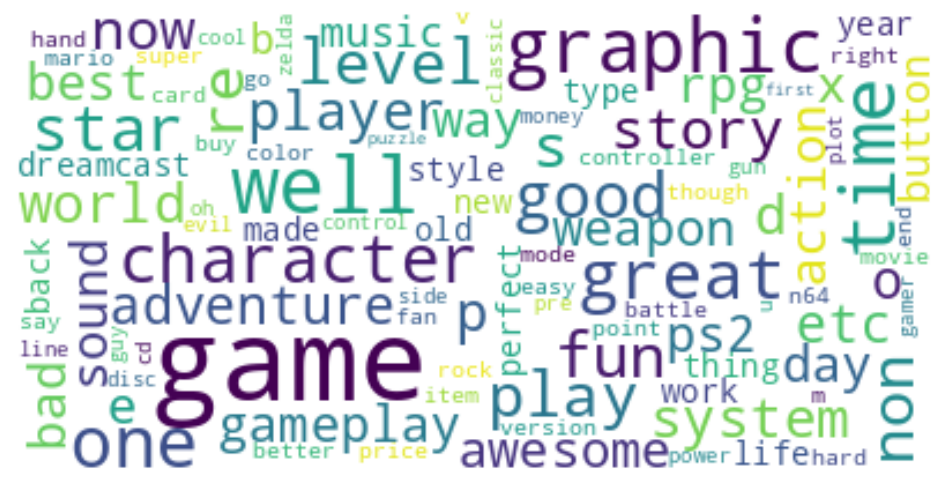

In [31]:
# Utilizo la funcion creada para hayar el wordcloud del vocabulario obtenido


plot_word_cloud(vocabulary_)

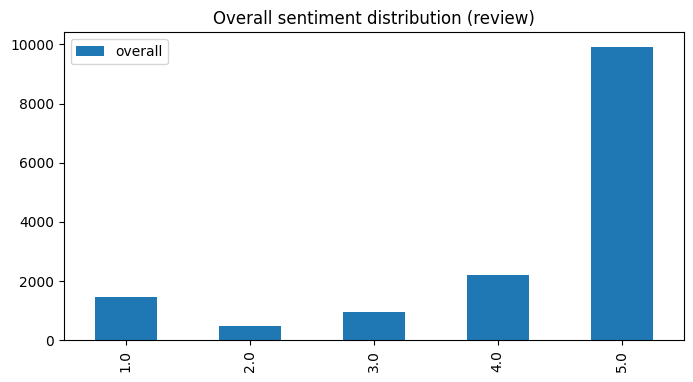

In [32]:
# Hago el diagrama de barras del overall para saber el numero de valoraciones de cada tipo y saber que tipo de datos tengo

aux_df = pd.DataFrame(lenguage_limited['overall'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

In [33]:
# Contamos el número de cores en el ordenador

cores = multiprocessing.cpu_count() # Contamos el número de cores en el ordenador
print (cores)

2


In [34]:
# creo una variable con lenguage_limited limpio de nan

clean_reviews = lenguage_limited['reviewText'].dropna().reset_index(drop=True)

In [35]:
# hago un df de la lista que tenia en clean_reviews para prepararlo para procesarlo
reviews_word2 =  pd.DataFrame(clean_reviews)

In [36]:
reviews_word2.shape

(14997, 1)

In [37]:
reviews_word2.head(10)

,reviewText
0,I used to play this game years ago and loved i...
1,The game itself worked great but the story lin...
2,I had to learn the hard way after ordering thi...
3,The product description should state this clea...
4,I would recommend this learning game for anyon...
5,Choose your career which sets your money for t...
6,Would like it more if they had at least update...
7,It took a few hours to get this up and running...
8,I oredered this for a daughter who is now 33 a...
9,Well I thought since this idem didn't have any...


In [38]:
# Calcular la longitud de cada texto y guardarla en una nueva columna
longitudes = reviews_word2['reviewText'].apply(lambda x: len(x))

# Calcular la longitud máxima y mínima
longitud_maxima = longitudes.max()
longitud_minima = longitudes.min()

# Imprimir la longitud máxima y mínima
print("Longitud máxima de los textos:", longitud_maxima)
print("Longitud mínima de los textos:", longitud_minima)

Longitud máxima de los textos: 30298
Longitud mínima de los textos: 1


In [39]:
# Creo una estancia con el word2vec con estos hiperparametros

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [40]:
reviews_word2

,reviewText
0,I used to play this game years ago and loved i...
1,The game itself worked great but the story lin...
2,I had to learn the hard way after ordering thi...
3,The product description should state this clea...
4,I would recommend this learning game for anyon...
...,...
14992,"When i received the game, I was so happy. Love..."
14993,The game is loved by all my family! I play all...
14994,My first amazon order and im glad i made the c...
14995,I've been playing this game for a long time an...


In [41]:
# Accedo al la columna 'reviewText' del dataframe y lo convierto en una lista de lista de palabras
# Creo el vocabulario

reviews_word2 = [row.split() for row in reviews_word2['reviewText']]
w2v_model.build_vocab(reviews_word2, progress_per=10000)


In [42]:
# Accedo a los vectores y despues a las palabras del vocabulario
keyed_vectors = w2v_model.wv

palabras_vocabulario = keyed_vectors.index_to_key
palabras_vocabulario[:10]

['the', 'and', 'to', 'a', 'of', 'I', 'is', 'game', 'you', 'it']

In [43]:
# entreno el modelo con los datos obtenido con el modelo

w2v_model.train(reviews_word2, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(13711007, 41671650)

In [44]:
# Guardo el modelo

w2v_model.save('./w2v_model.pkl')

In [45]:
# Busco las palabras mas similares a una palabra dada (game)

w2v_model.wv.most_similar(positive=["game"])

[('game,', 0.5041699409484863),
 ('game.', 0.4034871757030487),
 ('it', 0.3737652003765106),
 ('It', 0.3425111174583435),
 ('games', 0.3331714868545532),
 ('game!', 0.3126052916049957),
 ('classic,', 0.31233373284339905),
 ('videogame', 0.2805219888687134),
 ('n64.', 0.27980029582977295),
 ('truely', 0.2795092463493347)]

In [46]:
# busco las 10 palabras mas similares a las palabras definidas en keys, medianteword2vec y los vectores de las palabras

keys = ['level','joystick','technology','graphic']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [47]:
print(word_clusters)

[['level,', 'level.', 'stage.', 'levels', 'mission,', 'settings.', 'race,', 'goals', 'levels.', 'sections'], ['directional', 'analog', 'pad', 'controller.', 'thumb', 'R', 'joystick,', 'Z', 'comfortable', 'buttons'], ['era', 'hardware', 'impact', 'models', 'industry', 'capabilities', 'standards,', 'leap', 'production', 'producing'], ['textures', 'presentation', 'visuals', 'physics', 'incredible,', 'blocky', 'animation', 'graphics', 'sprites', 'linear']]


In [48]:
# Creo un estancia TSNE con las dimesiones que quiero

tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

In [49]:
# convierto embedding_clusters en un np.array y saco sus dimensiones

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

In [50]:
# Transformo el array en las dimensiones que necesito

embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

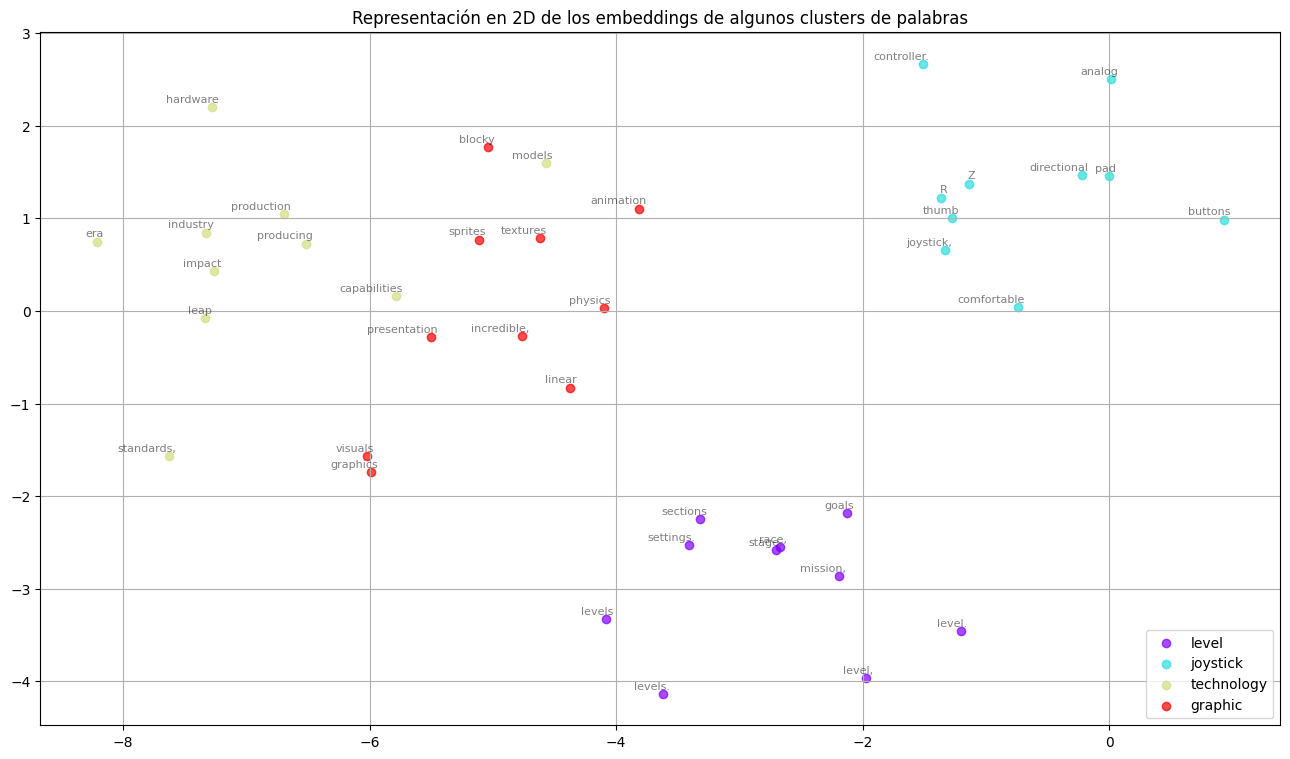

In [51]:
# Aplico la funcion para hacer la visualizacion 2D de las palabras similares


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

# conclusiones

Las conclusiones de la exploracion de los datos es que es un corpus en el que las palabras mas frecuentes son palabras sin mucha importancia ni significado, asi que podemos utilizar stopwords en el preprocesado para limpiar el corpus. Tambien podemos ver, analizando los bigrams y los trigrams, que nos afirmamos en el uso de stopwords para limpiar el corpus. Con el wordcloud vemos las palabras mas usadas y podemos interpretar que el corpus trata de videos juegos y de su valoracion, ademas, tambien se aprecia ligeramente que las valoraciones no estan balanceadas porque aparecen palabras que se pueden relacionar con una buena valoracion. Esta apreciacion la confirmamos con los diagramas de las valoracion, tomando 3, 4 y 5 como valoraciones buenas, hay mas valoraciones positivas que negativas. Podemos decir que el corpus no esta balanceado y debemos tenerlo en cuenta en el preprocesado